<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [673]:
%%capture
pip install pyswarms

In [674]:
%%capture
!pip install numpy==1.26

In [675]:
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [676]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [677]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 20000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 4000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_quarto_cenario'
NOME_ARQUIVO_CICLO_TEMPO_SEVERIDADE = 'ciclo_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '04'

In [678]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [679]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [680]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [681]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [682]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [683]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [684]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [685]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [686]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [687]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [688]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [689]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-10-28 16:08:30,419 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0817
2023-10-28 16:08:30,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08169066754596162, best pos: [147.61920888   1.00424319   0.77389247]


In [690]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 147.61920887881615
beta: 1.0042431854747604
theta: 0.773892468691408

Tempo de Convergência para a primeira etapa: 0.011930227279663086 segundos


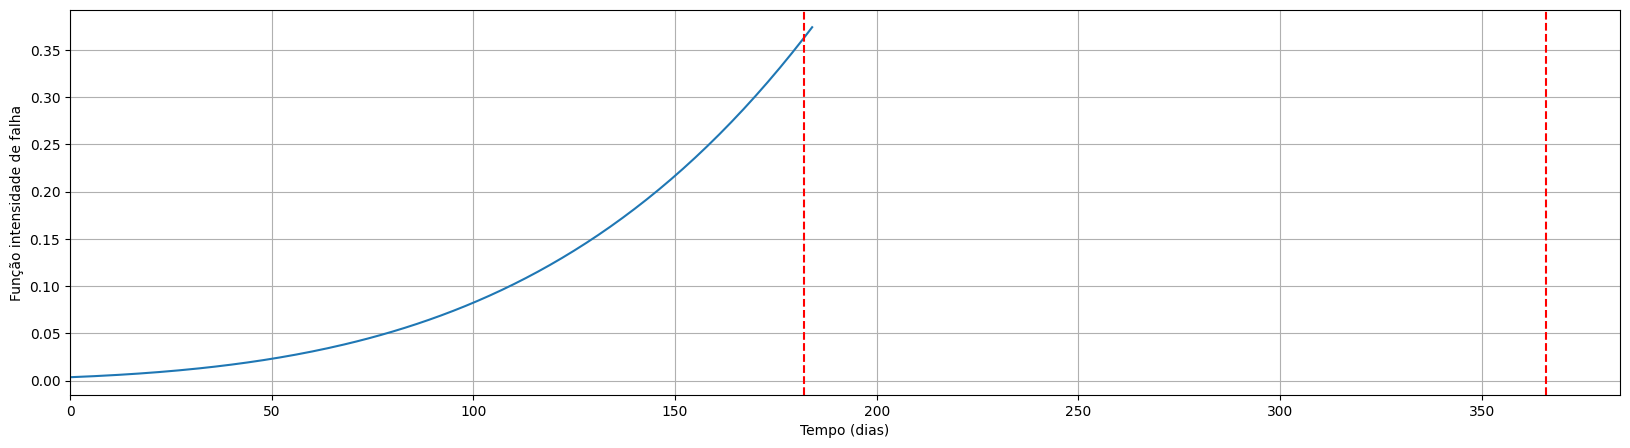

Fator ajuste:  [0.5387856924797234, 0.5387856924797234, 0.5387856924797234, 0.5387856924797234, 0.5387856924797234, 0.3208723923147605, 0.3208723923147605, 0.5387856924797234, 0.3208723923147605, 0.5387856924797234, 0.3208723923147605, 0.5387856924797234, 0.5387856924797234, 0.5387856924797234]


In [691]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [692]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [693]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-28 16:08:32,092 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  10%|█         |10/100, best_cost=6.3e+4 



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 67, 106, 134, 200, 217, 256, 291, 301, 364, 407, 479, 613, 660]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.3208723923147605, 0.44033637844107665, 0.44033637844107665]
Media de falhas:  [0, 0.018940050760368886, 0.04198410434384793, 0.10333767915930736, 2.318287070530956, 2.575923219919409, 7.0104056765562675, 8.72878632703824, 11.33160647186704, 18.958338158007457, 52.70341524880745, 78.93782901244833, 212.06976870475233, 341.72705429826954, 480.7770213023621]
Custo =  115285.79346657022


Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 4, 71, 379, 404, 5

pyswarms.single.global_best:  30%|███       |30/100, best_cost=6.3e+4



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 53, 67, 119, 243, 371, 392, 500, 513, 560, 640, 699]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.0068819208425226815, 0.20043682005888802, 7.843000339918986, 37.36424448142667, 44.61277035467125, 132.07481658915268, 161.30456112116474, 193.50795596793307, 286.93820318788556, 707.4803404601967, 839.2825032787036]
Custo =  255722.69743180723


Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 1, 48, 63, 131, 248, 333, 371, 394, 450, 509, 515, 562, 652, 705]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=6.3e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 53, 67, 103, 153, 240, 318, 373, 395, 450, 508, 513, 562, 638]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.0068819208425226815, 0.08887079622499684, 0.6623945012298145, 4.128024512011333, 14.200229338979652, 28.55140593518317, 32.276462800528456, 63.40325700857264, 173.01536002372637, 175.47359224042938, 209.51531241078231, 297.1808832601133, 1031.53419748955]
Custo =  204561.06078216998


Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 55, 69, 108, 154, 301,

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=6.3e+4

Custo =  209775.4154054362


Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 7, 58, 73, 93, 128, 153, 207, 302, 344, 384, 490, 557, 641]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 2.2474238917384845e-07, 0.006549543979697923, 0.01675582438469958, 0.05233046609931338, 0.2610665359247024, 0.4401834793585404, 1.6711958437420549, 11.342685269564459, 27.705346923489763, 33.70149476298587, 183.96349183964702, 273.5124746966698, 372.22391247229586, 1086.8773464661108]
Custo =  191062.29321336414


Número de ciclos de manutenção: 9 2
Tempos para manutenções preventiva

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=6.3e+4<ipython-input-692-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.3e+4
2023-10-28 16:08:33,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.0956543  1.80259266 1.30783379 5.40553284 2.64408604 3.14842364
 0.77371776 1.50260648 3.02376699 4.34816245 5.07593936 1.93996892
 4.69281078 1.30655448 5.39051338 5.23157661 5.89285582 5.13050873
 1.68435598 3.97095081 4.07029416 3.46636207 2.5151527  2.77272593]
2023-10-28 16:08:33,121 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 24, 57, 68, 115, 124, 154, 190, 229, 240, 317, 392, 424, 498, 511, 559, 632]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.00010929591361314598, 0.00241815955502271, 0.008392285479955084, 0.16509338116284297, 0.22743339622797196, 0.4434581625019707, 1.0488570220168807, 2.456349763186708, 2.9882551965107833, 21.287971811073014, 44.46631151058158, 51.63976096899742, 174.49808108602107, 180.75321800257964, 213.39654114322184, 294.4763312

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.27993378 1.79216905 1.38326397 3.98306621 2.3745554  3.15174855
 0.77412237 6.03928307 3.02371658 4.34393839 5.08643547 1.93886066
 5.50250779 1.30648642 5.39189107 5.22890306 5.89337179 5.13436565
 1.68446727 3.89894055 4.08020551 3.47025672 2.53027993 2.77272798]
2023-10-28 16:08:33,139 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 24, 54, 72, 153, 205, 310, 346, 391, 507, 555, 634]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.00010929591361314598, 0.0017291449392522627, 0.007633722538252457, 0.7729536124407688, 2.885334478079045, 14.666952713157963, 29.407110137125983, 36.65524927749301, 222.20126602447397, 357.09287817378396, 445.9268476797702, 1206.1687361723266]
Custo =  213683.37382931175


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11907141 1.75225477 1.38349777 6.12948338 2.47515591 3.14554754
 0.7733111  6.82133207 3.02371954 4.3443687  5.09409073 1.93935684
 6.77036314 1.30561618 5.39116534 5.22833358 5.89438666 5.13162759
 1.6845074  3.9441205  4.07974281 3.46936392 2.5272571  2.77272755]
2023-10-28 16:08:33,155 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 53, 73, 130, 153, 239, 307, 353, 393, 452, 503, 555, 599, 634]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.008129272766290045, 0.3104506615380812, 0.6414359147332553, 4.012404491526681, 11.733834381540156, 31.380975498478897, 37.96405703958689, 106.03925330773757, 200.4206574009882, 234.7406445312174, 274.3340209031299, 450.43638225505674, 827.7826504921381]
Custo =  215761.39638241765


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4



Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 53, 73, 98, 153, 207, 233, 240, 302, 359, 396, 431, 456, 500, 510, 555, 595, 629, 634]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.008129272766290045, 0.06024940145826266, 0.6685953631791136, 1.899607727562628, 2.9516294320538905, 3.295726052172007, 16.033492640194936, 28.680263242562333, 34.96458216600883, 70.82816447739242, 104.27504540000987, 123.3768665764


2023-10-28 16:08:33,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.97404165 1.72726681 1.36527894 0.14994788 2.59269966 3.14012228
 0.77262516 0.4402556  3.02373186 4.34582894 5.09789998 1.93990704
 6.83632971 1.30500377 5.39050054 5.22842211 5.89484239 5.12907654
 1.68453534 3.9926534  4.07899774 3.46824603 2.52429214 2.77272709]
2023-10-28 16:08:33,169 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.84352864 1.71110705 1.33235739 1.54825375 2.70784624 3.13547109
 0.77229612 1.93826259 3.02375057 4.34747581 5.10110339 1.94040591
 5.86712938 1.30460189 5.38990488 5.22919336 5.89505544 5.1269806
 1.68454162 4.0306965  4.07831226 3.46721912 2.52016874 2.77272662]
2023-10-28 16:08:33



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 52, 72, 137, 154, 184, 227, 240, 399, 441, 459, 499, 512, 556, 592, 627, 636]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005305038929452301, 0.007484678137336918, 0.4195364722001471, 0.6855580903071808, 1.5760559729742072, 3.0549908977926843, 3.3519429066925346, 83.03722753515811, 105.45126701508828, 130.77689267626786, 148.02405970254608, 154.3286746541471, 183.64300132990036, 214.62469651442223, 382.87927380469745, 405.49595658

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.78796303 1.72235206 1.2963799  3.18358858 2.79289329 3.13466208
 0.77206931 3.93774294 3.02376967 4.34903187 5.09874213 1.94079813
 4.16228722 1.30431736 5.38944342 5.23008816 5.89478473 5.12561659
 1.68449881 4.0645112  4.07696359 3.46614111 2.51546767 2.77272614]
2023-10-28 16:08:33,203 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 24, 52, 72, 102, 154, 220, 241, 402, 448, 463, 500, 513, 557, 590, 626, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.00010929591361314598, 0.0013694810107873498, 0.007844413855610237, 0.07786176637926687, 0.6826731162424599, 1.7809874040473268, 2.7748100230803567, 85.7617891881168, 111.74929304581951, 133.83529081120616, 149.9356242097835, 156.29001071455656, 185.817651185211, 213.86651976669378, 385.37874494657757, 421.17381712

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.74203577 1.74083402 1.26689282 4.20095797 2.82735209 3.13788669
 0.77199857 6.1666948  3.02378675 4.35020106 5.09007011 1.94109062
 1.97660929 1.30435436 5.38927091 5.23090572 5.89406756 5.12441194
 1.68444771 4.07784957 4.07512671 3.46521779 2.51117579 2.77272565]
2023-10-28 16:08:33,218 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 4, 52, 71, 154, 216, 241, 404, 465, 502, 515, 560, 591, 627, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.3531267272168034e-08, 0.004289285642444428, 0.01495965994110279, 0.8141651694599671, 3.796150600324757, 4.96242804629489, 90.41824951865087, 129.52698743205488, 200.32172736986865, 206.77654218897405, 237.62748559202925, 264.1798916696763, 436.8206849316033, 481.1850807272491, 822.9449154458736]
Custo =  251934.52804153707


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,246 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.74721472 1.75891041 1.24925721 4.47454063 2.81620861 3.14343619
 0.7722156  0.48379565 3.02380157 4.35073706 5.07892602 1.94132244
 6.96639514 1.30466145 5.38927851 5.23164533 5.8931605  5.12367164
 1.68438561 4.0819243  4.07233683 3.46440298 2.50809216 2.77272525]
2023-10-28 16:08:33,248 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 22, 53, 69, 122, 154, 214, 241, 405, 465, 504, 516, 562, 592, 628, 648]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 7.060889270720354e-05, 0.0017066947304285956, 0.004152305032978221, 0.22272817623135197, 0.6594982150177544, 3.461938311407336, 4.712803730113399, 91.42380980676374, 129.95656152102188, 205.3618756635737, 211.37101418860723, 243.35496738951684, 269.2381940169402, 443.0131279807335, 496.2828864999275, 823.6153913816279]
Custo =  254486.1850595929

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.84250796 1.78334879 1.24962953 4.0463792  2.76109435 3.14889436
 0.7725188  2.44045883 3.02381337 4.35097334 5.06870212 1.94121659
 4.25710129 1.30527915 5.38961977 5.23229067 5.89232438 5.12502388
 1.6843214  4.06649269 4.06954639 3.46394942 2.50681092 2.77272489]
2023-10-28 16:08:33,262 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 53, 68, 93, 141, 154, 215, 241, 406, 463, 506, 517, 563, 595, 650]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007042149445918684, 0.04854697075252857, 0.4389333145969972, 0.6503460073150449, 3.5415982593619826, 4.750300705191311, 92.73048853513762, 128.8775512079611, 212.39343007787022, 217.94878690755837, 250.16297408112632, 278.3159240273257, 570.9058162127192, 890.9813850094404]
Custo =  222205.12876287173


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.00026518 1.80598103 1.26004374 3.06982606 2.7067057  3.15374337
 0.77288839 4.6507528  3.02382061 4.35076573 5.059816   1.94106575
 1.1234107  1.3061642  5.39016344 5.23280089 5.89160077 5.12653606
 1.68427031 4.04661177 4.06717335 3.46378748 2.50812421 2.77272465]
2023-10-28 16:08:33,282 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 53, 67, 155, 198, 216, 241, 406, 445, 461, 508, 516, 564, 598, 652]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.0068819208425226815, 0.8586002458524208, 2.4510063659535883, 3.0012610429614517, 3.576993250347963, 91.55718108029428, 113.28339256980544, 136.35246902962308, 158.08818242337034, 162.1056749297824, 195.94297742689318, 226.44314180084248, 518.0664954067407, 830.855617690818]
Custo =  223033.2315563294


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.16354797 1.82552845 1.27685421 1.87060829 2.65575272 3.15673018
 0.77322517 6.65247322 3.02381773 4.34980766 5.05566873 1.94091177
 4.82423685 1.30703353 5.39070518 5.23310562 5.89115161 5.12877652
 1.68424934 4.02740334 4.06570333 3.46440669 2.50949396 2.77272447]
2023-10-28 16:08:33,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 54, 67, 120, 154, 218, 241, 405, 440, 459, 509, 516, 564, 652]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007364900851839416, 0.21049837502324883, 0.6666455722511305, 2.4375477080423336, 3.518162265463333, 90.22916834211368, 108.99561480090081, 135.6384504157565, 158.92923647145616, 162.44714693196428, 196.28444942907507, 307.0207205463686, 947.2972102000801]
Custo =  209162.73407735134


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.2994398  1.83867278 1.29864973 0.81888629 2.60948    3.15843885
 0.77354542 1.948694   3.02380458 4.34863836 5.05410805 1.94062229
 1.1502075  1.30771563 5.39115337 5.23300841 5.8909329  5.13100098
 1.68424266 4.00269669 4.06491227 3.46523419 2.51201763 2.7727245 ]
2023-10-28 16:08:33,314 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 14, 54, 67, 135, 154, 219, 241, 300, 403, 434, 457, 515, 564, 650]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 7.2982981680969186e-06, 0.0030193852845617187, 0.00476807707315453, 0.40117327669480307, 0.6929112314910193, 2.5225325787275494, 3.5598957140850076, 15.49958336059968, 49.80012034512803, 57.438218999823185, 88.69611427378993, 116.98173149720057, 151.51479195328042, 258.40436970665036, 912.4597045387654]
Custo =  195746.89703745084


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.41760893 1.84939235 1.31904109 6.80697766 2.56943001 3.15985868
 0.7738527  4.60867564 3.02379195 4.34745699 5.05724222 1.94021466
 4.2265248  1.30820296 5.39143331 5.23275238 5.89130359 5.13297534
 1.68424629 3.98004269 4.0649288  3.46615762 2.51473695 2.77272475]
2023-10-28 16:08:33,326 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 54, 67, 144, 154, 189, 221, 241, 302, 401, 429, 455, 514, 563, 647]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007364900851839416, 0.5751852636748745, 0.7426585680437785, 1.320502599525088, 2.3401534912107707, 2.8019449344260448, 15.390056750739364, 47.8473778171971, 54.44064077129287, 88.79774253723434, 117.34333100965625, 151.63005872796148, 254.1106088836416, 928.6189090909057]
Custo =  193451.09892349463


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.48199375 1.85407325 1.33623424 4.91754789 2.54865867 3.16030554
 0.77410589 0.25328561 3.02377793 4.34643504 5.06365169 1.93979543
 0.10243724 1.30850704 5.39165748 5.23241336 5.89208668 5.1343882
 1.68425398 3.95808737 4.06642735 3.46704279 2.51722347 2.77272519]




Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 12, 54, 68, 101, 149, 154, 223, 241, 304, 356, 398, 425, 454, 509, 513, 561, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 3.365637328950354e-06, 0.0033831081523814054, 0.0071236023679514746, 0.07837943986726767, 0.5759692077708738, 0.6171096092265231, 2.6959516275400586, 3.5573488949832757, 16.814286828052964, 28.07364545518803, 35.34384910196332, 62.201196269992195, 99.79740293058427, 125.39357650732548

2023-10-28 16:08:33,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 26, 54, 68, 115, 142, 154, 190, 225, 240, 305, 352, 396, 423, 453, 508, 512, 559, 641]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.0001633623477973465, 0.001579376140511579, 0.0035832156112817343, 0.16028431129416965, 0.4326333514183819, 0.4784322621939881, 1.083831121708898, 2.272972469868937, 2.9868779645050045, 16.738425426512265, 26.55683375518867, 34.017272720940866, 60.35

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.45134834 1.84826419 1.35055249 2.62878793 2.5395515  3.15741568
 0.77424527 3.50113935 3.02376345 4.34557708 5.06993284 1.93942643
 3.2154955  1.30857346 5.39168334 5.23195914 5.89288917 5.13557582
 1.68426095 3.93869204 4.06891446 3.46775087 2.51938922 2.77272576]
2023-10-28 16:08:33,357 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 0, 54, 69, 131, 153, 227, 240, 306, 349, 394, 421, 453, 506, 512, 557, 639]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.0, 0.006411924412713653, 0.014420831596826843, 0.34301803972537837, 0.6625658336742212, 3.0435586168687627, 3.6671606872281775, 17.767136906286808, 26.51708497491454, 33.99183100069454, 59.82336849346356, 100.52312671341636, 124.61579763650407, 127.54034579230495, 157.72985907930325, 252.88985332929758, 980.703

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.45134834 1.84826419 1.35055249 2.62878793 2.5395515  3.15741568
 0.77424527 3.50113935 3.02376345 4.34557708 5.06993284 1.93942643
 3.2154955  1.30857346 5.39168334 5.23195914 5.89288917 5.13557582
 1.68426095 3.93869204 4.06891446 3.46775087 2.51938922 2.77272576]
2023-10-28 16:08:33,374 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 70, 98, 120, 153, 229, 240, 306, 349, 395, 420, 453, 505, 512, 557, 638]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007870201368991477, 0.06407518942213697, 0.17790186460794333, 0.30135250334175134, 2.8297216668416127, 3.3616271001656877, 17.46160331922432, 26.211551387852055, 33.92974016668559, 57.78695678840323, 99.61879666576337, 123.07341464169969, 126.48280233046185, 156.67231561746016, 250.083584


2023-10-28 16:08:33,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.25550371 1.82247969 1.36630812 1.44483178 2.54099247 3.15012192
 0.77421487 4.8834575  3.02374438 4.34552085 5.07965672 1.93909263
 1.09575734 1.30739488 5.39160902 5.2310544  5.8940308  5.13581698
 1.68429709 3.92439766 4.07317031 3.46878467 2.52159987 2.7727265 ]
2023-10-28 16:08:33,393 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 53, 70, 153, 185, 229, 240, 306, 350, 396, 422, 453, 504, 512, 557, 598, 639]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.00741554077122321, 0.7839055408775122, 1.7413705864474174, 3.306286360942101, 3.8381917942661765, 17.93816801332481, 26.97709128038946, 34.774272546861795, 59.984023996659474, 99.543876736476, 122.36878449159956, 126.26232304326005, 156.45183633025835, 193.1342971460644, 403.15905809490346

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,411 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.15118766 1.80800917 1.36429937 4.01642191 2.57296774 3.14692946
 0.77406363 2.74371872 3.02373883 4.34631518 5.08193267 1.93920792
 3.37176365 1.30666084 5.3914244  5.23074664 5.89418335 5.13405582
 1.68432024 3.92788303 4.07446567 3.46848713 2.52093919 2.77272664]
2023-10-28 16:08:33,412 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,425 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.04694431 1.79344044 1.34779725 6.52511983 2.60925888 3.14441649
 0.77385188 0.52516333 3.0237409  4.34738265 5.08283887 1.93934761
 5.49814657 1.30597622 5.39099097 5.23048879 5.89431074 5.13207219
 1.68434895 3.940167



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 12, 53, 70, 154, 205, 229, 240, 305, 353, 397, 424, 454, 503, 513, 557, 596, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 3.365637328950354e-06, 0.0030408733485104366, 0.008038514231201103, 0.8129644141139151, 2.897580541729246, 3.808508741856269, 4.340414175180344, 18.0919616371876, 28.215009535796455, 35.75164071076782, 62.349715651416986, 101.11247385977158, 122.87660301431305, 127.77480189389726, 157

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 53, 70, 98, 149, 154, 228, 240, 304, 357, 399, 426, 456, 504, 513, 558, 595, 642]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.00741554077122321, 0.06362052882436871, 0.5803948541847104, 0.6215352556403597, 4.853799642236137, 5.43173119726065, 18.840141123688824, 30.425465544573143, 37.76957209795676, 64.88808672678364, 104.3594509611237, 125.85581339016395, 130.267367490532, 160.676

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,446 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.9629488  1.78093921 1.32363378 1.65403403 2.64306553 3.14263747
 0.7736337  5.63356145 3.02374991 4.34835188 5.08236621 1.93961555
 0.30240751 1.30544345 5.39059044 5.23042003 5.89429556 5.1301374
 1.68437479 3.95979885 4.07551136 3.46755888 2.51666155 2.77272663]
2023-10-28 16:08:33,448 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.92648977 1.77102933 1.30094404 4.37067423 2.67351564 3.14273294
 0.77345259 3.54866749 3.02376063 4.3492073  5.08074144 1.93990129
 3.09747552 1.30501831 5.39021074 5.23051346 5.8940661  5.12840003
 1.68439646 3.9799803



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 23, 53, 70, 146, 154, 202, 226, 240, 303, 400, 429, 457, 505, 514, 559, 595, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 8.826626579730214e-05, 0.0016191205766952254, 0.01092303975234047, 0.6098575884207996, 0.746516895795025, 2.622195952699931, 3.485066874982036, 3.804532387333051, 16.87503540021728, 48.43064357124978, 55.25597777892086, 92.67812022634534, 114.34699951437437, 118.79329264316509, 14

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 53, 69, 146, 154, 225, 241, 302, 401, 432, 458, 505, 514, 561, 595, 645]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.6108036035871408, 0.7474629109613662, 4.637727682079121, 5.409268048488873, 17.99737986480219, 50.45470093125993, 57.9517522903219, 93.24906315789957, 114.47170632433287, 118.91799945312358, 151.35402487629813, 181.24145121784676, 441.86066640448877, 780.0243317620739]
Custo =  213417.9026075405


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,472 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.94092881 1.76424911 1.28160153 0.00714039 2.69631347 3.1434741
 0.77336612 1.49573469 3.02377053 4.34996039 5.07871355 1.94017815
 5.86579259 1.30487558 5.38995448 5.23062527 5.89375522 5.12684439
 1.68441589 3.99629606 4.07498824 3.46597866 2.51213843 2.77272615]
2023-10-28 16:08:33,474 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 53, 69, 95, 147, 154, 224, 241, 301, 401, 435, 459, 506, 514, 562, 596, 647]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.05395843707144342, 0.546721896170472, 0.6674970234931094, 4.448301592633203, 5.264932464949071, 17.526311573497978, 50.26974622178135, 58.714294661682416, 91.80949159801948, 113.20213337255143, 117.15728405700412, 150.51311795362912, 180.60375192593744, 449.237314022

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.99475817 1.76563883 1.26809919 3.84186821 2.7098412  3.14428205
 0.77332234 6.64811469 3.02377859 4.35020689 5.07664831 1.94039575
 1.29353138 1.30476483 5.38975967 5.23075037 5.89342375 5.12544542
 1.68442307 4.00590819 4.07347583 3.46530881 2.51051919 2.77272586]
2023-10-28 16:08:33,488 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 8, 53, 69, 93, 154, 204, 223, 241, 300, 401, 437, 460, 507, 515, 562, 597, 648]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 4.394152055939127e-07, 0.003813299870450623, 0.012195484967407685, 0.052578699425440745, 0.719055167976131, 1.3191551821209666, 1.9783629570603396, 2.3945735364557392, 14.334261182970412, 47.363516331103256, 56.46478556979267, 88.57219120096046, 110.13585501016148, 114.1220850350257

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.0696933  1.77572373 1.26699692 0.67306501 2.71347219 3.14593377
 0.77337546 4.17423963 3.02378432 4.35022328 5.07460741 1.94055081
 3.61519833 1.30508903 5.3896662  5.23102359 5.89296821 5.12520698
 1.68442097 4.01374667 4.07157468 3.46487698 2.50941482 2.7727256 ]
2023-10-28 16:08:33,506 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 16, 53, 68, 111, 154, 193, 222, 241, 400, 438, 460, 508, 515, 562, 598, 629, 647]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.4269596411290423e-05, 0.0024079553845376333, 0.006380794577085461, 0.1334370607438308, 0.6690629638292503, 1.9986639606356964, 2.949964733045797, 3.388969922244526, 83.96170821019776, 103.83872970687467, 134.6528340017856, 156.84552464153953, 160.336064568495, 193.0059832541512, 225

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,520 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.14198205 1.78778759 1.26780143 4.57773229 2.71126467 3.14744037
 0.7734946  1.41868882 3.02378834 4.3498833  5.07301056 1.94062464
 5.85015249 1.30579279 5.38967008 5.23141758 5.89255084 5.12550686
 1.68441355 4.01801938 4.06980142 3.46491664 2.5088053  2.77272538]
2023-10-28 16:08:33,521 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 21, 54, 68, 115, 154, 201, 222, 241, 399, 439, 460, 508, 514, 562, 599, 629, 647]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 5.5900261164510906e-05, 0.0020237949745407074, 0.004027634445310863, 0.16072873012819877, 0.6624833684220095, 1.1919844182896782, 1.9016688748642836, 2.3406740640630126, 81.72648195269569, 102.76175673713718, 132.27369503286027, 154.4663856726142, 157.43719705693067, 190.79303095355


2023-10-28 16:08:33,535 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.19903841 1.80259699 1.27088292 1.32996985 2.69973772 3.14894525
 0.77365557 5.952342   3.02378885 4.34954841 5.07236609 1.94055087
 0.67578681 1.30647929 5.38971177 5.23181365 5.89224423 5.12632088
 1.68439581 4.01491711 4.0683368  3.46497566 2.50904507 2.77272534]
2023-10-28 16:08:33,536 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.24404667 1.81592455 1.28150232 4.75323242 2.67881311 3.15028459
 0.77380116 3.38031993 3.02378521 4.34884202 5.0719319  1.9403889
 2.56092972 1.30711392 5.38976966 5.23212976 5.89213503 5.12774241
 1.68437743 4.00300765 4.0671578  3.46520382 2.50964527 2.77272539]
2023-10-28 16:08:33



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 54, 68, 154, 223, 240, 398, 438, 460, 508, 514, 561, 629, 646]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.0075164015200110245, 0.823850290629805, 4.497407328009581, 5.300280915079978, 83.80961118942386, 104.6490801307167, 135.46318442562765, 157.65587506538157, 160.62668644969804, 193.06271187287257, 267.1939683533008, 363.63364875157174, 698.1940771621482]
Custo =  227816.70807472104


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 22, 54, 68, 116, 121, 154, 224, 240, 300, 358, 397, 436, 458, 507, 513, 560, 629, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 7.060889270720354e-05, 0.0019165330443839607, 0.009074019436257894, 0.1739456457541872, 0.2068649953126304, 0.33354670929141406, 2.4784083719681416, 3.2369612456421373, 15.324528236094997, 28.020117850147116, 34.70786172873643, 76.05422547295814, 106.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,563 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.25976415 1.82617573 1.29567464 0.9599346  2.65231984 3.15132791
 0.77392399 0.7834494  3.0237792  4.34809684 5.07188778 1.94018855
 4.82680143 1.30758381 5.39000091 5.23239961 5.89206634 5.12968573
 1.68436011 3.98722781 4.0664641  3.46554724 2.51183075 2.7727255 ]
2023-10-28 16:08:33,568 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 15, 54, 68, 115, 124, 154, 225, 240, 301, 355, 397, 433, 457, 507, 513, 559, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 1.0319850757883452e-05, 0.002850974158121107, 0.006591468373691176, 0.16329256405657908, 0.22563257912170806, 0.6423194350564954, 2.8547390055850936, 3.5686445002211613, 15.978785482979452, 27.48783930023341, 34.68470182981741, 72.15726485785375, 104.6649894377071, 127.5889761688536

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.26913904 1.83509647 1.30881263 4.5594686  2.62808262 3.15158513
 0.77401147 5.60978246 3.02377215 4.34743883 5.07270214 1.93996318
 6.85206355 1.30771441 5.39026501 5.2326423  5.89219987 5.13149021
 1.68434333 3.97287875 4.06603885 3.46600625 2.51417015 2.77272568]
2023-10-28 16:08:33,583 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.27500063 1.8342457  1.32057073 0.8929085  2.61088102 3.15123457
 0.7740342  3.33428273 3.02376467 4.3468674  5.07431116 1.93976077
 1.27614165 1.30771666 5.39052426 5.23266674 5.89242021 5.13297392
 1.68433038 3.959426



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 4, 54, 69, 100, 122, 154, 225, 240, 301, 352, 397, 431, 456, 506, 513, 559, 642]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 1.3531267272168034e-08, 0.005226053382810764, 0.007509327238084989, 0.0730776068463766, 0.1952302504108382, 0.3178773451662772, 2.5302969156948754, 3.244202410330943, 15.654343393089235, 26.216014342723263, 33.92266790254554, 68.88320556178756, 102.33008648440502, 125.0723138696910

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 104, 154, 226, 240, 302, 350, 397, 429, 455, 505, 513, 558, 599, 641]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.09175931478397789, 0.6819364836488574, 4.683908250464748, 5.352832546621533, 18.090599134644464, 27.863312848950905, 35.91033911829332, 68.41417083138509, 102.77127259732656, 125.33282833317918, 129.25708209915462, 159.66587407075355, 196.5965029544384, 414.01501189

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,619 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.25272536 1.83160185 1.32961264 4.54179227 2.60131979 3.15033518
 0.77398018 0.9052779  3.02375818 4.34641984 5.07580418 1.9396329
 2.6404243  1.30737749 5.39075622 5.23238963 5.89271361 5.13388573
 1.68432297 3.94825025 4.06650281 3.46698519 2.51850647 2.7727261 ]
2023-10-28 16:08:33,620 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 203, 226, 240, 303, 351, 398, 427, 454, 505, 513, 558, 599, 641]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 2.762061096184561, 3.592077382148887, 5.0023002167632615, 18.07280322964749, 27.961262357547707, 36.090217084213876, 65.29172068864767, 100.53057134645316, 123.53860147638329, 127.46285524235873, 157.87164721395766, 194.8022760976425, 412.220785037

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,636 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.21217695 1.82835947 1.33621732 0.97057855 2.60077481 3.14929487
 0.77387221 5.88306274 3.02375419 4.34610358 5.07715295 1.93954684
 4.18458438 1.30695044 5.39096009 5.23207248 5.89300746 5.13386337
 1.6843196  3.94012755 4.06795691 3.46734217 2.51947267 2.77272625]
2023-10-28 16:08:33,637 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.1716481  1.81821473 1.33424211 5.16068711 2.61204399 3.14810336
 0.77375098 3.47170759 3.02375132 4.34635239 5.07828925 1.93951774
 5.64202834 1.30650446 5.39114204 5.23173161 5.893227   5.13310872
 1.68432516 3.938498



Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 22, 54, 69, 92, 154, 194, 226, 240, 303, 353, 398, 425, 454, 505, 513, 558, 598, 641]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 7.060889270720354e-05, 0.0019165330443839607, 0.009925440228497152, 0.047359238192330275, 0.7203284956996922, 2.10500086516316, 3.223344986893606, 3.892269283050391, 16.96277229593462, 27.461889835441617, 35.24703808753658, 62.104385255565454, 99.70059

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 18, 54, 69, 154, 190, 226, 240, 304, 355, 399, 425, 455, 505, 513, 558, 597, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 2.577861322462391e-05, 0.002398290723972805, 0.006619155927995684, 0.8172539619771181, 1.9894580289042931, 3.231216539266336, 3.550682051617351, 16.959091978045524, 27.897517147094398, 35.58829095815169, 61.543664469437, 100.65951946049805, 123.22107519635068, 127.14532896232612, 15

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,662 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11278035 1.80779821 1.32624778 1.96434276 2.63006937 3.14703254
 0.77363883 1.16170889 3.02375221 4.34673749 5.07912398 1.93952777
 6.86745648 1.3061099  5.39128989 5.23139966 5.89336622 5.13198619
 1.68433601 3.93761332 4.07140192 3.46736775 2.51922778 2.77272631]
2023-10-28 16:08:33,663 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 12, 53, 69, 154, 226, 240, 304, 358, 399, 424, 455, 505, 513, 558, 597, 642]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 3.365637328950354e-06, 0.0030408733485104366, 0.005486483651060062, 0.8161212897001825, 4.818093056516074, 5.487017352672859, 18.895427279101032, 30.81180888507757, 37.9826975228385, 62.78803776415853, 103.07327702481233, 125.63483276066495, 129.55908652664039, 159.96787849823932, 194.65070175638485, 427.4457392

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.05590257 1.79784139 1.31875673 6.08644661 2.64757649 3.14613243
 0.77355257 6.12178439 3.02375493 4.34739839 5.07963632 1.93965855
 0.63515145 1.30583947 5.39132423 5.23110202 5.89342812 5.13088812
 1.68435078 3.94584039 4.07276122 3.46733516 2.51857593 2.77272622]
2023-10-28 16:08:33,678 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.00678116 1.78941311 1.31123593 2.77416765 2.66324713 3.14593634
 0.77352257 3.27174496 3.0237587  4.34809194 5.0796471  1.93979116
 2.44902637 1.30575198 5.39113399 5.23096253 5.89347468 5.12989346
 1.6843656  3.960157



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 53, 69, 154, 225, 240, 303, 400, 424, 456, 505, 513, 559, 597, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.817854378558943, 4.708119149676698, 5.422024644312765, 18.492527657196995, 50.0481358282295, 55.45010141541292, 97.27400061173351, 119.38917840757291, 123.31343217354835, 154.6141096221031, 188.4200934442479, 427.35926656187206, 772.7082645776086]
Custo =  211409.04702782162


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 53, 69, 93, 154, 198, 225, 240, 303, 400, 426, 456, 505, 513, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.0476027869678537, 0.714079255518544, 1.179094362358823, 2.1218686532710915, 3.623261535334427, 16.693764548218656, 48.249372719251156, 54.20699861859455, 93.67836285293461, 115.79354064877401, 119.71779441474945, 151.92118926151778, 185.95626508322113, 426.4336133418

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,703 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.97060766 1.78188681 1.30413587 6.84852964 2.67352547 3.146207
 0.77350663 0.41692989 3.02376391 4.34871675 5.0788393  1.93995344
 4.67069448 1.3058271  5.39095943 5.23086971 5.89340212 5.12917241
 1.68437634 3.97574945 4.07349513 3.46713685 2.51660679 2.77272597]
2023-10-28 16:08:33,705 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 53, 69, 154, 193, 224, 240, 302, 400, 429, 457, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.817854378558943, 2.147455375365389, 3.1953697319148686, 3.9539226055888643, 16.691689193611793, 48.53109627689477, 55.35643048456585, 92.77857293199034, 115.07086590371813, 119.02601658817082, 150.55321941137868, 184.58829523308202, 425.0656434917289, 766.8254782103534]
Custo =  213100.2930548081



2023-10-28 16:08:33,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.96234123 1.77952436 1.29856438 3.44289118 2.67723586 3.14686888
 0.77353106 5.09192412 3.02376924 4.34919906 5.07809905 1.94010298
 6.67170206 1.30602337 5.39075126 5.23084694 5.8932417  5.12855871
 1.68438043 3.98855602 4.07286421 3.46689698 2.51553149 2.77272585]
2023-10-28 16:08:33,726 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,737 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.96147526 1.7803612  1.29358811 0.06954587 2.67839518 3.14757078
 0.77358483 2.06352414 3.02377401 4.34956128 5.0770815  1.94022156
 1.25893464 1.30623354 5.39056219 5.23093325 5.89298528 5.12819119
 1.68437806 3.99964281 4.07171623 3.46667452 2.51451919 2.77272574]
2023-10-28 16:08:3



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 23, 53, 69, 108, 154, 196, 224, 240, 302, 400, 432, 457, 506, 514, 561, 599, 645]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 8.826626579730214e-05, 0.0016191205766952254, 0.006084557087189645, 0.11220635351104986, 0.6718913295666777, 1.4600237900514768, 2.416506818097073, 2.7809213806513937, 15.518687968674325, 47.35809505195731, 55.093536328996784, 88.84253668594744, 111.13482965767523, 115.08998034212792,

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 7, 53, 68, 154, 224, 240, 301, 400, 434, 458, 506, 514, 561, 599, 645]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 2.2474238917384845e-07, 0.004029711413225675, 0.006184659360477773, 0.8225185484702717, 4.6033231176103655, 5.361875991284361, 17.77201697404265, 49.89490729188892, 58.26139945222093, 91.06187170893458, 112.90430851594795, 116.85945920040064, 149.2954846235752, 183.56081815672633, 425.58377417914517, 763.7474395367303]
Custo =  215811.070432370

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [3.98317547 1.78561977 1.28993644 4.60141288 2.67423616 3.14838656
 0.77366175 6.25357824 3.02377711 4.34979013 5.07615226 1.94025362
 3.37927657 1.30644908 5.39039105 5.23105796 5.89271827 5.12850121
 1.6843747  4.00728843 4.07028923 3.46639972 2.51374942 2.77272567]
2023-10-28 16:08:33,756 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.00355423 1.79325047 1.28741903 1.86199024 2.66591413 3.14912172
 0.77374654 2.65708953 3.02377844 4.34997243 5.07530254 1.94020551
 5.58676172 1.30664383 5.39023936 5.23117997 5.8925056  5.12886531
 1.6843704  4.009572



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 53, 68, 117, 154, 199, 224, 240, 301, 400, 436, 458, 506, 514, 561, 645]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007042149445918684, 0.1804062855619647, 0.6643805836337976, 2.345046685611479, 3.2084026574530218, 3.9669555311270175, 16.37709651388531, 48.499986831731576, 57.5175213227739, 87.78670038815524, 109.62913719516861, 113.5842878796213, 146.02031330279584, 247.2326369513998, 935.234401854769]
Custo =  202156.79564393905


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 54, 68, 154, 224, 240, 301, 358, 399, 436, 457, 506, 514, 561, 645]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.0075164015200110245, 0.823850290629805, 4.604654859769899, 5.363207733443894, 17.773348716202186, 30.275059393221724, 37.44594803098265, 76.9417472874893, 105.67406693146833, 127.96635990319612, 131.9215105876488, 164.35753601082337, 265.5698596594273, 953.5716245627964]
Custo =  214807.80960357364


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.02448411 1.80105511 1.29019321 6.06993511 2.65400517 3.14957763
 0.77381489 6.21173977 3.02377918 4.35009643 5.07467838 1.9401153
 0.56799193 1.30681177 5.39012392 5.23139707 5.89239087 5.1292946
 1.68436557 4.00120844 4.06798433 3.46596349 2.51298348 2.77272574]
2023-10-28 16:08:33,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.06380972 1.80829185 1.29318372 2.7064422  2.6417615  3.14995049
 0.77385067 2.84016244 3.02377913 4.34992868 5.07436769 1.94001611
 3.45809527 1.30691455 5.39008433 5.23160759 5.89231887 5.12973192
 1.6843591  3.99277805



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 68, 154, 200, 224, 240, 301, 356, 399, 435, 457, 507, 514, 561, 645]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.0075164015200110245, 0.823850290629805, 2.568017863936886, 3.3999284587919427, 4.99131051798424, 17.40145150074253, 29.23628192913029, 36.75368003706387, 74.94899769721434, 104.94844610229099, 127.87243283343754, 131.33576253999925, 163.77178796317378, 264.98411161177773, 952.9858765151469]
Custo =  215985.9154906832

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 15, 54, 69, 105, 154, 224, 240, 301, 355, 399, 435, 456, 507, 514, 561, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 1.0319850757883452e-05, 0.002850974158121107, 0.010859881342234298, 0.10009634236028718, 0.6828089550101615, 2.8276706176868887, 3.5862234913608844, 15.996364474119176, 27.505418291373132, 35.19619210243042, 73.39150976258088, 101.86742919777109, 125.24502244468763, 128.70835215124936, 161.1443775744239, 260.530

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10778904 1.81430738 1.29806507 6.20375426 2.63135873 3.14985156
 0.77385295 6.63491785 3.02377683 4.34965272 5.07414007 1.93991811
 6.15163151 1.3069962  5.3901334  5.23178894 5.89238382 5.13021349
 1.68435273 3.98395196 4.0671943  3.46592575 2.51353915 2.77272596]
2023-10-28 16:08:33,813 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 10, 54, 69, 154, 225, 240, 301, 354, 398, 433, 456, 507, 514, 560, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 1.347352343482622e-06, 0.003783784938388902, 0.00800465014241178, 0.8186394561915342, 4.708904227309289, 5.422809721945357, 17.83295070470365, 29.0212580477503, 36.63466650183095, 73.19274323085706, 104.17125856290515, 127.5488518098217, 131.0121815163834, 162.53938433959127, 261.3066036798775, 962.6896990178795]
Custo =  213876.96968235326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.14407512 1.81676386 1.30431084 2.2780062  2.62302237 3.14945822
 0.77383594 2.47456243 3.02377361 4.3491631  5.07400146 1.93983742
 1.57495801 1.30701351 5.39025339 5.23193261 5.89252033 5.13072903
 1.6843479  3.97302693 4.06763043 3.46596822 2.51408382 2.77272606]
2023-10-28 16:08:33,829 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.17140353 1.81691306 1.31054288 5.59271003 2.61582591 3.14903236
 0.77380619 5.72698871 3.02376946 4.34864311 5.07404094 1.93976857
 3.82655637 1.30692585 5.39037113 5.23205235 5.89266747 5.13116114
 1.68434573 3.962690



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 1, 54, 69, 116, 154, 225, 240, 302, 354, 398, 432, 456, 507, 513, 560, 643]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605]
Media de falhas:  [0, 1.2831140328956797e-11, 0.00609707162278, 0.008380345478054226, 0.17120424978765442, 0.6641427763987972, 4.5544075475165515, 5.268313042152619, 18.00607963017555, 29.006421722032186, 36.61983017611284, 71.91738296659982, 104.13432797732935, 127.5119212242459, 130.4595327998966, 162.66292764666494, 261.430146986

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.19457229 1.81628309 1.3161088  1.54286317 2.60966376 3.14862764
 0.77377087 2.23800458 3.02376547 4.34812918 5.07416127 1.93973479
 5.94115451 1.30680851 5.39047839 5.2321495  5.89282757 5.13139583
 1.68434656 3.95567187 4.06891522 3.46621324 2.51568863 2.77272617]
2023-10-28 16:08:33,857 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 189, 225, 240, 302, 355, 398, 430, 455, 507, 513, 559, 599, 642]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 1.9405847643540934, 3.159775022292414, 3.5017267554723652, 16.239493343495297, 27.558980313207705, 35.000744044235496, 67.81890881368909, 100.96570760331755, 124.79701872204058, 127.74463029769127, 159.045307746246, 195.0878207035911, 418.588561074

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 186, 225, 240, 302, 357, 398, 429, 455, 507, 513, 559, 599, 642]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 1.7980286359619382, 3.1064977028588583, 4.607890584922194, 17.345657172945124, 29.318526661068326, 36.417244407878016, 68.01631394604605, 102.37341571198752, 126.20472683071054, 129.15233840636125, 160.45301585491598, 196.49552881226106, 419.996269

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,870 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.19107629 1.81194265 1.3190382  5.06778923 2.60571784 3.14823802
 0.77372864 6.04483845 3.02376205 4.34766741 5.07441323 1.93976546
 0.56551881 1.30668104 5.39058512 5.23208164 5.89297976 5.13159441
 1.68434874 3.94954386 4.06970311 3.46635992 2.51625276 2.77272616]
2023-10-28 16:08:33,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 8, 54, 69, 95, 154, 225, 240, 302, 358, 398, 429, 455, 506, 513, 559, 599, 642]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 4.394152055939127e-07, 0.004223085656719495, 0.012231992840832685, 0.058970857402455466, 0.7122678802402413, 4.602532651357996, 5.316438145994064, 18.054204734016995, 30.361430105219018, 37.288725663354846, 68.88779520152288, 103.24489696746434, 126.437154107575, 129.8734332774669, 


2023-10-28 16:08:33,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.18187362 1.8068523  1.32116652 1.29469619 2.60318331 3.14791761
 0.77368786 2.65470601 3.02375934 4.34730387 5.07470464 1.93980732
 2.37911446 1.30652873 5.39067269 5.23199698 5.89308979 5.13151113
 1.68435119 3.94504839 4.07052443 3.46649247 2.5164375  2.77272615]
2023-10-28 16:08:33,885 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 95, 154, 225, 240, 302, 359, 398, 428, 456, 506, 513, 559, 598, 642]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.054423261530241, 0.7077202843680269, 2.9201398548966253, 3.634045349532693, 16.371811937555623, 29.018582539923017, 35.77450912907057, 66.16806293293484, 103.2544219526888, 125.99664933797484, 129.43292850786673, 160.73360595642146, 195.65146426073056, 423.810653802987


2023-10-28 16:08:33,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.16483541 1.80142378 1.32136145 5.0586537  2.61066968 3.14769621
 0.77365713 6.40261342 3.02375903 4.34709628 5.07527562 1.93985576
 4.67003454 1.30639809 5.39072893 5.23189609 5.89315471 5.13118128
 1.68435429 3.94853548 4.07124471 3.46661145 2.51656297 2.77272607]
2023-10-28 16:08:33,899 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 100, 154, 225, 240, 302, 399, 429, 456, 506, 513, 559, 598, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.07325267657690981, 0.6923285567918789, 1.9960208220009337, 2.7099263166370013, 15.447692904659931, 46.67732978263895, 53.73462743197155, 89.61615235550292, 112.35837974078896, 115.79465891068084, 147.09533635923557, 182.01319466354468, 416.3084377780284, 761.657435793765]
Custo =  212254.290518068

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.13288497 1.79673187 1.32027251 1.46261898 2.62729433 3.14767383
 0.77363627 2.71073737 3.02376029 4.34719618 5.07595044 1.939925
 6.73813515 1.30630064 5.39074769 5.23172454 5.89320411 5.13068961
 1.68435747 3.95498483 4.07176652 3.46670134 2.51635546 2.77272597]
2023-10-28 16:08:33,914 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 53, 69, 154, 225, 240, 302, 399, 429, 456, 506, 513, 560, 598, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.817854378558943, 4.708119149676698, 5.422024644312765, 18.159791232335696, 49.38942811031472, 56.44672575964732, 92.32825068317868, 115.07047806846472, 118.5067572383566, 150.71015208512495, 184.7452279068283, 419.04047102131204, 764.3894690370486]
Custo =  212395.92169365557


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.1031813  1.7932325  1.31670219 4.63218998 2.64551045 3.14783922
 0.77363412 6.0595609  3.02376175 4.34751302 5.07655457 1.93999528
 1.59351127 1.30625923 5.39073013 5.23153301 5.89323317 5.13022672
 1.68435997 3.96425732 4.0721861  3.46670673 2.51611311 2.77272589]
2023-10-28 16:08:33,930 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.07512751 1.79087859 1.31337807 0.70075224 2.66151017 3.14802987
 0.77363875 1.93489018 3.02376456 4.34788654 5.07702764 1.94005178
 4.17990251 1.30624094 5.39067644 5.23136725 5.89325737 5.12983602
 1.68436161 3.972677



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 53, 69, 154, 224, 240, 302, 399, 430, 457, 506, 513, 560, 598, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.817854378558943, 4.598658947699037, 5.357211821373032, 18.094978409395964, 49.32461528737498, 56.68258796589574, 92.8887339567595, 115.18102692848728, 118.61730609837916, 150.8207009451475, 184.85577676685085, 419.1510198813346, 764.5000178970711]
Custo =  212570.68415908885


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 11, 53, 69, 114, 154, 224, 240, 302, 359, 399, 431, 457, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 2.174316652792325e-06, 0.003220459895763873, 0.011602644992720934, 0.15850794963727383, 0.6689350388385373, 1.9293960356361457, 2.6879489093101414, 15.425715497333073, 28.07248609970047, 35.07021993257676, 68.20499779322026, 103.1867841383999, 125.47907711012769, 129.4342277945803

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.0505336  1.78956925 1.30981925 4.81304745 2.67530623 3.14830177
 0.77365491 5.12329289 3.02376743 4.3482397  5.0772505  1.94008764
 6.51570499 1.30630556 5.39059055 5.23121921 5.89316594 5.12957399
 1.68436178 3.98020774 4.07219154 3.46655066 2.51537878 2.77272575]
2023-10-28 16:08:33,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 53, 69, 100, 154, 224, 240, 302, 359, 399, 433, 457, 506, 514, 561, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.07278785211811224, 0.6918637323330813, 4.472668301473175, 5.23122117514717, 17.9689877631701, 30.615758365537495, 37.61349219841379, 73.25049713443296, 105.75822171428632, 128.0505146860141, 132.0056653704668, 164.44169079364133, 197.59363058395786, 438.070978842604

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.03340695 1.79021577 1.30619661 1.6364277  2.68646719 3.14857293
 0.77367647 0.83405391 3.02376993 4.34855131 5.07733741 1.94011908
 1.22707219 1.30639517 5.39049702 5.23111008 5.89307744 5.12961551
 1.6843602  3.98530607 4.07195725 3.4664364  2.51493606 2.77272573]
2023-10-28 16:08:33,972 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:33,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.03561606 1.79192636 1.30302534 5.23198263 2.6932801  3.14880422
 0.77370676 3.99044649 3.02377199 4.34881731 5.07722579 1.94011725
 2.8750341  1.30651845 5.39041427 5.23101215 5.89294985 5.12976609
 1.68435872 3.988292



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 53, 69, 154, 224, 240, 301, 358, 399, 433, 457, 506, 514, 561, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.005837497590720495, 0.007219572509820637, 0.817854378558943, 4.598658947699037, 5.357211821373032, 17.767352804131324, 30.269063481150862, 37.43995211891179, 73.07695705493097, 105.58468163478435, 127.87697460651214, 131.83212529096483, 164.26815071413938, 197.4200905044559, 437.89743876310274, 779.6572734817272]
Custo =  226380.6481424718


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 22, 54, 69, 154, 205, 224, 240, 302, 357, 399, 434, 457, 506, 514, 561, 598, 644]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 7.060889270720354e-05, 0.0019165330443839607, 0.004199806899658187, 0.8148346129487806, 2.8994507405641112, 3.5708527586182477, 4.329405632292243, 17.06717222031517, 29.040041708438373, 36.38414826182199, 73.29324039358984, 104.5511356675566, 126.84342863928438, 130.79857932373707, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,007 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.04612967 1.79619004 1.3010176  1.49083013 2.69065105 3.14892377
 0.77373537 0.17504456 3.02377371 4.3490529  5.07711108 1.9400914
 4.62682718 1.30663735 5.39035541 5.23098745 5.89282281 5.13006686
 1.68435662 3.98677363 4.07044215 3.4662344  2.5142478  2.77272583]
2023-10-28 16:08:34,008 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.05768922 1.80131528 1.29927672 4.90570876 2.67731365 3.14890613
 0.77375972 3.88567086 3.02377369 4.349064   5.07694588 1.94006123
 6.21530789 1.306734   5.39033069 5.23099489 5.89271742 5.13044353
 1.68435462 3.9830317



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 119, 154, 224, 240, 302, 357, 399, 435, 457, 506, 514, 561, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.19681270748998725, 0.662395989840459, 2.8072576525171864, 3.565810526191182, 16.303577114214114, 28.276446602337316, 35.620553155720934, 73.81587081587139, 103.81531922094804, 126.10761219267583, 130.0627628771285, 162.49878830030303, 195.65072809061957, 436.128076349

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 224, 240, 302, 357, 398, 435, 457, 506, 514, 561, 599, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.599123772157834, 5.3576766458318295, 18.09544323385476, 30.06831272197796, 37.16703046878765, 76.28839766723597, 106.28784607231262, 128.5801390440404, 132.5352897284931, 164.97131515166762, 199.23664868481876, 435.0393540660932, 776.7991887847177]
Custo =  226926.29674164383


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.07372425 1.80616628 1.29814053 1.11579795 2.65588756 3.14876293
 0.77377904 0.4154331  3.02377189 4.34882212 5.07652149 1.94001905
 0.51356477 1.3067769  5.39033353 5.23108902 5.89263049 5.13079087
 1.6843532  3.97911012 4.06898536 3.46614705 2.51416528 2.77272597]
2023-10-28 16:08:34,036 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 54, 69, 102, 154, 184, 225, 240, 302, 357, 398, 434, 456, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.08209223307315566, 0.6869035829363486, 1.1383779595992385, 2.505694744557659, 2.8476464777376105, 15.585413065760541, 27.558282553883743, 34.65700030069343, 72.48964276648442, 102.22117091685267, 124.9633983021387, 128.3996774720306, 16

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08917401 1.80982205 1.2987521  4.61251676 2.63606345 3.14856535
 0.77379067 4.45618554 3.02377015 4.34849063 5.07610408 1.93998047
 1.83165021 1.30681551 5.39036728 5.23124832 5.8925718  5.13103918
 1.68435266 3.97465778 4.06875523 3.46612557 2.51434014 2.77272603]
2023-10-28 16:08:34,050 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 357, 398, 434, 456, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.133125544917696, 37.23184329172739, 75.06448575751838, 104.79601390788663, 127.53824129317266, 130.97452046306455, 163.17791530983288, 198.33200468693735, 434.1347100682118, 775.8945447868363]
Custo =  226760.4647728016

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10346023 1.81198067 1.29949991 0.93808699 2.6192595  3.14838096
 0.77379394 0.94241174 3.02376806 4.34813268 5.07568752 1.93994513
 3.73528157 1.30681653 5.39040808 5.2314075  5.89259384 5.1311497
 1.68435285 3.96961244 4.06868917 3.4661362  2.51457391 2.77272607]
2023-10-28 16:08:34,066 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11485321 1.81173467 1.30183898 5.06327589 2.60695131 3.14821963
 0.77378218 4.87699748 3.02376612 4.34781516 5.0753423  1.93991458
 5.49569128 1.30677134 5.39047582 5.23156712 5.89267313 5.13115743
 1.68435391 3.9651745



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 24, 54, 69, 154, 190, 225, 240, 302, 357, 398, 433, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.00010929591361314598, 0.0017291449392522627, 0.004012418794526488, 0.8146472248436489, 1.9868512917708239, 3.175992639930863, 3.8898981345669306, 16.627664722589863, 28.600534210713064, 35.699251957522755, 72.25732868654887, 103.23584401859696, 125.978071403883, 129.4143505737749,

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 3, 54, 69, 154, 225, 240, 302, 357, 398, 432, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 3.1914944842574265e-09, 0.0055045056151269344, 0.007787779470401161, 0.8184225855195236, 4.708687356637278, 5.422592851273346, 18.160359439296275, 30.13322892741948, 37.23194667422917, 72.52949946471614, 104.74644447544567, 127.4886718607317, 130.9249510306236, 163.12834587739192, 198.2824352544964, 427.911155090

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.12222797 1.81012352 1.30422688 1.8164531  2.59588653 3.14809914
 0.77375297 1.42928266 3.02376447 4.34757411 5.07511512 1.93989193
 6.88655291 1.30670423 5.39053808 5.23171107 5.89279074 5.13098964
 1.68435542 3.96180455 4.06945975 3.46624098 2.51528503 2.7727261 ]
2023-10-28 16:08:34,093 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.467481427996518, 37.63837006575744, 70.77314792640092, 104.22002884901838, 126.96225623430442, 130.3985354041963, 162.60193025096464, 197.7560196280691, 427.3847394644421, 772.7337374801787]
Custo =  225975.3990050659


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,110 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.12138729 1.80784113 1.30667174 5.46443842 2.5891373  3.14805551
 0.77371899 5.34780599 3.02376308 4.34742086 5.07492787 1.93988233
 0.60942705 1.3066235  5.3905869  5.23181666 5.89290983 5.13075429
 1.68435694 3.96008427 4.06989863 3.46631702 2.51561315 2.77272608]
2023-10-28 16:08:34,111 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.12047953 1.80476827 1.30905428 1.73208135 2.58712973 3.14805981
 0.77368837 2.04311067 3.0237623  4.34742371 5.07482231 1.93988441
 1.87862975 1.30654732 5.39061494 5.23186468 5.89300252 5.13050617
 1.68435817 3.959105



Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 19, 54, 69, 105, 154, 201, 225, 240, 302, 358, 399, 430, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 3.3819190105300184e-05, 0.002264753250846006, 0.006485618454868884, 0.09572207947292177, 0.6784346921227961, 1.6436376539483981, 2.4909219421114424, 2.8328736752913937, 15.570640263314324, 27.877865634516347, 35.04875427227728, 66.95316003670031, 101.62

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 1, 54, 69, 154, 202, 225, 240, 302, 358, 399, 430, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.2831140328956797e-11, 0.00609707162278, 0.01031793682680288, 0.8209527428759253, 2.696631799780832, 3.511664775071894, 5.01305765713523, 17.75082424515816, 30.058049616360183, 37.22893825412111, 69.13334401854414, 103.80173052886157, 126.5439579141476, 129.9802370840395, 162.183631

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11827052 1.80189518 1.31099101 5.36604845 2.5933063  3.14809235
 0.77366754 5.91379213 3.02376284 4.34748067 5.07482821 1.93991154
 3.52349619 1.30648015 5.39062446 5.23189283 5.8930471  5.13028351
 1.68435899 3.9617771  4.07082225 3.46645472 2.5158484  2.77272599]
2023-10-28 16:08:34,139 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 184, 225, 240, 302, 359, 399, 430, 456, 506, 513, 560, 598, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 1.7088170856847669, 3.0761338706431873, 3.4180856038231386, 16.15585219184607, 28.802622794213462, 35.800356627089755, 67.70476239151279, 102.37314890183022, 125.11537628711625, 128.55165545700814, 160.75505030377647, 194.79012612547982, 429.085369

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,155 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11328015 1.79949178 1.31263429 1.63681503 2.61169724 3.14812744
 0.77365096 2.51152431 3.02376374 4.34769954 5.07495139 1.93994812
 5.0775726  1.30643018 5.39061457 5.23190628 5.89307744 5.13013444
 1.68435961 3.96670677 4.0711219  3.46649346 2.51586278 2.77272592]
2023-10-28 16:08:34,156 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10845913 1.79785778 1.3139897  4.76036906 2.63184426 3.14817667
 0.77363874 6.25668018 3.02376531 4.34800877 5.07514193 1.9399847
 6.46047212 1.30641596 5.39057982 5.23186578 5.89306278 5.13001952
 1.68436004 3.9717441



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 192, 225, 240, 302, 359, 399, 430, 456, 506, 513, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 2.0941675551946357, 3.222745520978563, 4.7241384030418985, 17.461904991064827, 30.108675593432224, 37.10640942630852, 69.01081519073155, 103.67920170104898, 126.42142908633502, 129.8577082562269, 162.06110310299525, 196.0961789246986, 436.573527183

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10137946 1.79655849 1.31354556 0.63452449 2.65129655 3.14829412
 0.77363158 2.07746058 3.02376718 4.34831395 5.07546772 1.94001472
 0.55064076 1.30641896 5.39053959 5.23177371 5.89303147 5.13005422
 1.68436015 3.97604121 4.0713991  3.46652684 2.51553165 2.77272582]




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 224, 240, 302, 359, 399, 430, 456, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.599123772157834, 5.3576766458318295, 18.09544323385476, 30.742213836222156, 37.73994766909845, 69.64435343352147, 104.3127399438389, 127.05496732912493, 131.01011801357762, 162.53732083678548, 196.57239665848883, 437.0497449171357, 778.8095796357602]
Custo =  225765.3611900041


2023-10-28 16:08:34,182 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,229 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09409594 1.79681294 1.31310955 4.32878824 2.6683811  3.14842092
 0.77363532 5.15326429 3.02376881 4.34858294 5.07577923 1.94002852
 2.73013265 1.30642728 5.39050214 5.23166784 5.89299841 5.1301247
 1.68435922 3.97895827 4.07120574 3.46652328 2.51527633 2.77272577]
2023-10-28 16:08:34,230 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 105, 154, 224, 240, 302, 359, 399, 430, 457, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.09692085798667109, 0.6796334706365453, 2.8244951333132726, 3.5830480069872683, 16.320814595010198, 28.967585197377595, 35.96531903025389, 67.86972479467693, 104.07587078554069, 126.36816375726848, 130.32331444172115, 161.850517264929, 195.88559308663235, 436.362941345

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 224, 240, 302, 358, 399, 431, 457, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.599123772157834, 5.3576766458318295, 18.09544323385476, 30.402668605056782, 37.573557242817714, 70.7083351034612, 105.69012144864084, 127.98241442036863, 131.93756510482132, 163.46476792802918, 197.49984374973252, 437.97719200837935, 779.7370267270038]
Custo =  226002.017911499

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08779656 1.79797709 1.31207497 0.75762603 2.67807441 3.14853562
 0.77365333 0.93363636 3.02376974 4.34875045 5.07608595 1.94003707
 4.82179545 1.30645306 5.39046941 5.23155263 5.89293283 5.13019906
 1.68435767 3.98133406 4.07099616 3.46650242 2.515012   2.77272575]
2023-10-28 16:08:34,252 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,263 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08254023 1.80035482 1.30993659 4.37721945 2.67983952 3.14862753
 0.77368817 4.21221886 3.02377035 4.34873834 5.0763292  1.94004017
 6.66569575 1.3064971  5.3904513  5.23144899 5.89286525 5.13029714
 1.68435608 3.981067



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 4, 54, 69, 154, 224, 240, 302, 358, 399, 431, 457, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.3531267272168034e-08, 0.005226053382810764, 0.009446918586833643, 0.8200817246359561, 4.60088629377605, 5.359439167450045, 18.097205755472977, 30.404431126675, 37.57531976443593, 70.71009762507941, 105.69188397025906, 127.98417694198685, 131.93932762643954, 163.4665304496474, 197.50160627135074, 437.9789545299976

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08032872 1.8025602  1.30786091 0.89146238 2.67989157 3.1486906
 0.77372701 0.27191553 3.02377014 4.34863528 5.0764911  1.94003564
 1.066217   1.30654181 5.39043716 5.23138545 5.89280339 5.13042476
 1.68435464 3.97979841 4.07020421 3.46637898 2.51469764 2.77272576]
2023-10-28 16:08:34,282 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 16, 54, 69, 95, 154, 224, 240, 302, 358, 398, 432, 457, 506, 514, 560, 598, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.4269596411290423e-05, 0.0026913700325347147, 0.006912235236557593, 0.05365109979818038, 0.7069481226359663, 1.9674091194335745, 2.7259619931075703, 15.4637285811305, 27.770953952332523, 34.69824951046835, 69.99580230095532, 103.74480265790598, 126.03709562963377, 129.99224631408646

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,299 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.07854826 1.8045544  1.30598558 4.935605   2.6723002  3.14871794
 0.7737615  3.95123996 3.0237699  4.34847221 5.07650034 1.94001929
 2.77324895 1.30658295 5.39044231 5.23133916 5.8927633  5.13054382
 1.68435374 3.97644976 4.06986909 3.46631705 2.51466719 2.77272578]
2023-10-28 16:08:34,301 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 28, 54, 69, 154, 208, 225, 240, 302, 358, 398, 432, 457, 506, 514, 560, 599, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.00023700538356938002, 0.0014695970568733134, 0.005690462260896192, 0.8163252683100186, 3.1245366208220675, 3.741226824598085, 4.083178557778036, 16.820945145800966, 29.12817051700299, 36.05546607513882, 71.35301886562578, 105.10201922257644, 127.39431219430423, 131.34946287875692,

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 54, 69, 106, 154, 200, 225, 240, 302, 357, 398, 432, 457, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.10231081675118953, 0.6774557082620571, 1.6053155232455518, 2.4846366171572645, 3.9860294992206002, 16.72379608724353, 28.696665575366737, 35.79538332217643, 71.09293611266341, 104.84193646961407, 127.13422944134186, 130.57050861123375, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,318 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.0801342  1.80586038 1.30484951 1.71464282 2.66205108 3.14869487
 0.77379244 0.61102567 3.02376966 4.34824658 5.0764993  1.94000008
 4.59772387 1.3066151  5.39046812 5.23134949 5.89274932 5.13064223
 1.68435331 3.97218902 4.06960997 3.46626234 2.51466456 2.77272583]
2023-10-28 16:08:34,319 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08429552 1.80613694 1.30459471 5.24933885 2.65269117 3.14860217
 0.77381644 4.65987009 3.02376892 4.34802108 5.07648067 1.93998228
 6.26701495 1.3066408  5.39050097 5.23140826 5.89275711 5.13070004
 1.68435328 3.968030



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 357, 398, 432, 457, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.133125544917696, 37.23184329172739, 72.52939608221436, 106.27839643916502, 128.5706894108928, 132.0069685807847, 164.21036342755303, 199.3644528046575, 435.16715818593195, 776.9269929045564]
Custo =  226507.7716130643


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09012906 1.80603603 1.30520163 1.46702124 2.6424035  3.14848132
 0.7738142  1.84189125 3.02376805 4.34781965 5.07643757 1.93996258
 0.48276708 1.30665892 5.39053405 5.23149359 5.89279311 5.13072819
 1.68435331 3.96442298 4.06961814 3.46620322 2.51471023 2.77272594]
2023-10-28 16:08:34,348 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 357, 398, 432, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.133125544917696, 37.23184329172739, 72.52939608221436, 104.7463410929439, 127.48856847822992, 130.9248476481218, 163.12824249489015, 198.28233187199461, 427.91105170836755, 773.2600497241041]
Custo =  226024.32008194557

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09595365 1.80575148 1.30590276 4.63025231 2.63347304 3.1483707
 0.77379788 6.29164539 3.02376699 4.34771941 5.07629986 1.93994552
 1.68020777 1.3066683  5.3905591  5.2315824  5.89282906 5.1307454
 1.68435341 3.96211523 4.06980773 3.46621203 2.51484506 2.77272598]
2023-10-28 16:08:34,366 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 185, 225, 240, 302, 357, 398, 432, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 1.7528549475799076, 3.0908116072177343, 3.804717101853802, 16.542483689876732, 28.515353177999934, 35.614070924809624, 70.9116237152966, 103.12856872602613, 125.87079611131216, 129.30707528120405, 161.51047012797238, 196.66455950507685, 426.293279341

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 357, 398, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.133125544917696, 37.23184329172739, 71.28279739500732, 104.72967831762477, 127.47190570291082, 130.9081848728027, 163.11157971957104, 198.2656690966755, 427.89438893304845, 773.243386948785]
Custo =  225852.80984104867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10118178 1.8048071  1.30696041 0.6166851  2.62777492 3.14827873
 0.77376014 2.76995345 3.02376603 4.3476361  5.07614152 1.93993268
 3.47392539 1.30666871 5.39057359 5.23166155 5.89286253 5.13075717
 1.68435382 3.96173465 4.07004593 3.46623119 2.51504678 2.77272601]
2023-10-28 16:08:34,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 54, 69, 110, 154, 202, 225, 240, 302, 357, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.1263075154184404, 0.6700742785252214, 1.6736242633343725, 2.4886572386254344, 3.99005012068877, 16.7278167087117, 28.7006861968349, 36.04479275021852, 69.17957061086202, 102.62645153347947, 125.36867891876551, 128.8049580886574, 161.008

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10586918 1.80391066 1.30812529 4.59657666 2.62276356 3.14823266
 0.7737217  6.2303937  3.02376521 4.34764705 5.07599329 1.93993
 5.17820166 1.30663786 5.39058619 5.23171381 5.89289255 5.13070875
 1.6843548  3.96224193 4.07028813 3.46626564 2.51525498 2.77272604]
2023-10-28 16:08:34,397 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  227081.37511782147


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10855506 1.80278586 1.30915954 1.25597886 2.61882473 3.14824587
 0.77368657 3.02007227 3.02376457 4.34769343 5.07585529 1.93993508
 6.59430691 1.30660587 5.39058871 5.23175742 5.89291732 5.13062367
 1.68435599 3.96447718 4.07050791 3.46630384 2.51544192 2.77272606]
2023-10-28 16:08:34,414 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.467481427996518, 37.63837006575744, 70.77314792640092, 104.22002884901838, 126.96225623430442, 130.3985354041963, 162.60193025096464, 197.7560196280691, 427.3847394644421, 772.7337374801787]
Custo =  225975.3990050659


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11036628 1.80176594 1.30976924 5.65316063 2.62225494 3.14829689
 0.77366189 0.0655783  3.02376404 4.3477779  5.07575308 1.93994754
 0.35393181 1.30656887 5.39057638 5.23175759 5.89293935 5.13051767
 1.68435705 3.96715533 4.07069883 3.46634463 2.515546   2.77272604]
2023-10-28 16:08:34,429 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 108, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.11380619339247842, 0.6734911694481063, 2.8859107399767048, 3.5998162346127724, 16.337582822635703, 28.644808193837726, 35.81569683159866, 68.95047469224215, 102.3973556148596, 125.13958300014565, 128.57586217003754, 160.77925701680587, 195.93334639391034, 425.56206623

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11074704 1.8009209  1.30988792 2.56037855 2.6307737  3.14834926
 0.77364072 4.63893858 3.02376366 4.34786954 5.07570109 1.93996504
 2.03769671 1.30653533 5.39055174 5.2317478  5.89293842 5.13042174
 1.68435798 3.97044855 4.07079667 3.46638181 2.51553102 2.77272602]
2023-10-28 16:08:34,445 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.467481427996518, 37.63837006575744, 70.77314792640092, 104.22002884901838, 126.96225623430442, 130.3985354041963, 162.60193025096464, 197.7560196280691, 427.3847394644421, 772.7337374801787]
Custo =  225975.3990050659


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.11080283 1.80032887 1.30972735 6.82326286 2.6386217  3.14840003
 0.77364382 2.36291179 3.02376427 4.34799864 5.07569633 1.93998175
 4.20916009 1.30650656 5.39052953 5.23169429 5.89291758 5.13034845
 1.68435836 3.97341381 4.07085299 3.46641189 2.51541159 2.772726  ]
2023-10-28 16:08:34,463 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 25, 54, 69, 110, 154, 205, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.00013416026015701114, 0.0016494277222607635, 0.005870292926283642, 0.12449341137610583, 0.6682601744828868, 1.793077243768491, 2.5100106297469207, 2.851962362926872, 15.589728950949802, 27.896954322151824, 35.06784295991275, 68.20262082055623, 101.649

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 19, 54, 69, 154, 208, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 598, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 3.3819190105300184e-05, 0.002264753250846006, 0.006485618454868884, 0.8171204245039912, 3.12533177701604, 3.7420219807920576, 5.243414862855393, 17.981181450878324, 30.288406822080347, 37.45929545984127, 70.59407332048477, 104.04095424310222, 126.78318162838826, 130.21946079828015, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.1084616  1.80044107 1.30951897 3.41551554 2.64619727 3.1484504
 0.77366431 0.17459016 3.02376517 4.34814624 5.07569768 1.93999296
 6.24763567 1.30648497 5.39050534 5.23162727 5.89288225 5.13030123
 1.68435847 3.97573267 4.07078444 3.46643272 2.51527711 2.77272597]
2023-10-28 16:08:34,484 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.1055739  1.80111623 1.30896343 6.96432255 2.6527757  3.14849364
 0.77369446 5.28479612 3.02376639 4.34828059 5.07572862 1.93999689
 1.05982107 1.30648366 5.39048441 5.23156138 5.89285017 5.13029414
 1.68435805 3.9769481



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 16, 54, 69, 154, 184, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 598, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.4269596411290423e-05, 0.0026913700325347147, 0.006912235236557593, 0.81754704128568, 1.7080449239527062, 3.075361708911127, 3.4173134420910785, 16.155080030114007, 28.46230540131603, 35.633194039076955, 68.76797189972044, 102.21485282233789, 124.95708020762393, 128.39335937751582,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10252724 1.80184463 1.30832698 2.99270835 2.65849109 3.14852882
 0.77372393 2.69406149 3.02376759 4.34839439 5.07579053 1.93999605
 2.75477159 1.30650131 5.39046905 5.23150481 5.8928226  5.13034016
 1.68435742 3.97628514 4.07048179 3.4664522  2.51499368 2.77272591]
2023-10-28 16:08:34,516 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 14, 54, 69, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 598, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 7.2982981680969186e-06, 0.0030193852845617187, 0.0072402504885845965, 0.817875056537707, 4.708139827655462, 5.422045322291529, 18.15981191031446, 30.467037281516482, 37.63792591927741, 70.7727037799209, 104.21958470253836, 126.9618120878244, 130.3980912577163, 162.60148610448462, 196.63656192618797, 437.1139101848

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 15, 54, 69, 154, 225, 240, 302, 358, 399, 431, 457, 506, 513, 560, 598, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.0319850757883452e-05, 0.002850974158121107, 0.007071839362143985, 0.8177066454112664, 4.707971416529021, 5.421876911165088, 18.159643499188018, 30.46686887039004, 37.63775750815097, 70.77253536879445, 105.7543217139741, 128.04661468570188, 131.48289385559377, 163.6862887023621, 197.72136452406545, 438.1987127827

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09866011 1.80252471 1.30774682 5.75829332 2.6599456  3.14853302
 0.77374986 0.24495233 3.02376854 4.34847917 5.07588081 1.93999283
 4.73518323 1.30652974 5.39046164 5.23145461 5.89280495 5.13041599
 1.68435649 3.97494573 4.07025648 3.46644352 2.51492061 2.77272588]
2023-10-28 16:08:34,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09455949 1.80314327 1.30724047 1.15246851 2.65882613 3.1485137
 0.77377009 5.36058578 3.02376922 4.34847399 5.07596395 1.93998478
 6.51539028 1.3065577  5.39046437 5.23143489 5.89279818 5.13050677
 1.68435558 3.9735578



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 15, 54, 69, 99, 154, 225, 240, 302, 358, 399, 432, 457, 506, 513, 560, 598, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 1.0319850757883452e-05, 0.002850974158121107, 0.007071839362143985, 0.06851356880554854, 0.6945916901068407, 4.584856461224596, 5.298761955860663, 18.036528543883595, 30.343753915085617, 37.514642552846546, 71.8935815426932, 105.64258189964386, 127.93487487137165, 131.37115404126354,

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 20, 54, 69, 96, 154, 225, 240, 302, 357, 399, 431, 457, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 4.375400286687238e-05, 0.0021399014001655162, 0.006360766604188394, 0.05651738425824725, 0.7031218054929647, 2.915541376021563, 3.6294468706576306, 16.36721345868056, 28.34008294680376, 35.68418950018738, 68.81896736083087, 103.80075370601051, 126.0930466777383, 129.5293258476302, 161.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09094681 1.80362177 1.30683975 3.46217092 2.65445841 3.14848686
 0.77377613 3.0483896  3.0237697  4.34838919 5.07603228 1.93997593
 0.69792562 1.30658243 5.39047219 5.23142673 5.8928006  5.13058899
 1.68435483 3.97165775 4.06994129 3.4664139  2.51497167 2.77272586]
2023-10-28 16:08:34,562 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 24, 54, 69, 100, 154, 225, 240, 302, 357, 399, 431, 456, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.00010929591361314598, 0.0017291449392522627, 0.005950010143275141, 0.07151828975156675, 0.6905941699665358, 1.9942864351755905, 2.708191929811658, 15.445958517834589, 27.418828005957792, 34.76293455934141, 67.8977124199849, 101.34459334260235, 124.08682072788838, 127.5230998977802

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08799035 1.8039944  1.30656706 5.65030978 2.64950312 3.1484444
 0.7737677  0.91965677 3.02376977 4.34828227 5.07607303 1.93996754
 2.11139309 1.3066013  5.39048687 5.23145571 5.89280669 5.13064365
 1.68435421 3.96975909 4.06991398 3.46638444 2.51503961 2.77272587]
2023-10-28 16:08:34,580 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08593254 1.80391827 1.30633389 0.59476597 2.64419597 3.14840314
 0.7737547  6.12939716 3.02376927 4.34815135 5.07610377 1.93996038
 3.56287635 1.30660873 5.39050182 5.23149844 5.89282528 5.13068122
 1.68435391 3.9681729



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 28, 54, 69, 154, 225, 240, 302, 357, 399, 431, 456, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.00023700538356938002, 0.0014695970568733134, 0.005690462260896192, 0.8163252683100186, 4.706590039427773, 5.420495534063841, 18.15826212208677, 30.131131610209977, 37.475238163593595, 70.61001602423708, 104.05689694685454, 126.79912433214056, 130.23540350203245, 162.4387983488008, 197.59288772590526, 433.3955931

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 357, 399, 431, 456, 506, 513, 560, 599, 644]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.133125544917696, 37.477232098301315, 70.61200995894481, 104.05889088156226, 126.8011182668483, 130.2373974367402, 162.44079228350853, 197.594881660613, 433.3975870418875, 775.157421760512]
Custo =  226326.27697505004


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08646284 1.80377374 1.30647716 2.87861056 2.63940591 3.14837128
 0.77373871 3.85702831 3.02376842 4.34803539 5.07610972 1.93995425
 5.08954071 1.30660007 5.39051619 5.23155659 5.89285053 5.13071246
 1.68435414 3.96732611 4.07001503 3.46633404 2.51522146 2.77272592]
2023-10-28 16:08:34,610 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.08942779 1.80353078 1.30684077 5.65688654 2.63590405 3.14834337
 0.77371946 1.47331597 3.02376748 4.34793997 5.07610876 1.93994952
 6.43935025 1.30657895 5.39052855 5.23161436 5.89287329 5.13069315
 1.68435483 3.966681



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 225, 240, 302, 357, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 4.708583974135495, 5.422489468771563, 18.160256056794495, 30.133125544917696, 37.477232098301315, 70.61200995894481, 104.05889088156226, 126.8011182668483, 130.2373974367402, 162.44079228350853, 197.594881660613, 427.2236014969859, 772.5725995127225]
Custo =  225943.03608786946


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 187, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 1.8443600211094546, 3.1232089272585313, 4.624601809321867, 17.362368397344795, 29.669593768546818, 36.84048240630774, 69.97526026695124, 103.42214118956869, 126.16436857485473, 129.60064774474662, 161.80404259151496, 196.95813196861943, 426.5868518

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.09384101 1.80328261 1.30742535 1.11506659 2.633012   3.14833296
 0.77370191 6.33095289 3.0237665  4.34789113 5.0760806  1.93995095
 0.48188531 1.30655377 5.39053858 5.23165742 5.89289201 5.13066915
 1.68435566 3.96660797 4.07030668 3.46631132 2.51530965 2.77272596]
2023-10-28 16:08:34,651 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,667 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.0980821  1.80299793 1.3079983  4.10463381 2.63100748 3.14834666
 0.77369073 4.34962665 3.02376563 4.34789434 5.0760243  1.93995508
 2.05897272 1.30653124 5.39054078 5.23169187 5.89290796 5.13060972
 1.68435649 3.966707



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 54, 69, 92, 154, 195, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.04511819493245134, 0.7180874524398133, 2.1591740828397183, 3.195662536545164, 3.537614269725115, 16.275380857748047, 28.58260622895007, 35.753494866710994, 68.88827272735449, 102.33515364997194, 125.07738103525799, 128.51366020514988, 

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 90, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.03964843620685684, 0.7254238068064318, 2.93784337733503, 3.6517488719710975, 16.38951545999403, 28.696740831196053, 35.86762946895698, 69.00240732960046, 102.44928825221791, 125.19151563750395, 128.62779480739584, 160.83118965416418, 195.98527903126865, 425.61399886764

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10186973 1.80271825 1.30849666 0.06384602 2.63258528 3.14836169
 0.7736825  2.32104171 3.02376505 4.34793388 5.0759543  1.93995962
 3.69614993 1.30651262 5.3905367  5.23171159 5.8929151  5.13055242
 1.68435711 3.96683848 4.0705358  3.46633015 2.51526477 2.77272598]
2023-10-28 16:08:34,684 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10474952 1.80245682 1.30881092 2.93576719 2.63556345 3.14838114
 0.77368271 0.47478567 3.02376481 4.34798846 5.07588688 1.93996489
 5.32167402 1.30649733 5.39052675 5.23172834 5.89291287 5.13049202
 1.68435747 3.967130



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 204, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 2.8316977248198754, 3.581561158176769, 3.92351289135672, 16.66127947937965, 28.968504850581674, 36.139393488342606, 69.2741713489861, 102.72105227160355, 125.4632796568896, 128.8995588267815, 161.10295367354982, 196.2570430506543, 425.8857628870272

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 154, 205, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.8183192030177406, 2.9029353306330714, 3.619868716611501, 5.121261598674836, 17.859028186697767, 30.16625355789979, 37.33714219566072, 70.47192005630421, 103.91880097892167, 126.66102836420771, 130.0973075340996, 162.30070238086793, 197.4547917579724, 427.08351159434

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.1051935  1.80225251 1.30891415 5.8665979  2.63880814 3.14840149
 0.77368343 6.10689607 3.02376524 4.34804953 5.07583349 1.93996981
 6.74036929 1.30648494 5.39051378 5.23173313 5.89290109 5.13043871
 1.68435752 3.96758219 4.0704918  3.46636008 2.5151761  2.77272596]
2023-10-28 16:08:34,721 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10483669 1.80214428 1.30890944 1.44802044 2.64316186 3.14842199
 0.77368933 4.8454294  3.02376607 4.3481137  5.07581231 1.93997417
 0.60311902 1.30648969 5.39050207 5.23169056 5.8928794  5.13040901
 1.68435712 3.968326



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 54, 69, 108, 154, 182, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.11380619339247842, 0.6734911694481063, 1.4792347156173964, 2.9049095328079924, 3.2468612659879437, 15.984627854010874, 28.291853225212897, 35.46274186297383, 68.59751972361732, 102.04440064623478, 124.78662803152082, 128.2229072014127

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.3e+4



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 54, 69, 116, 154, 225, 240, 302, 358, 399, 431, 456, 506, 513, 560, 599, 643]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5387856924797234, 0.17590801018015012, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605, 0.17590801018015012, 0.3208723923147605, 0.44033637844107665, 0.17590801018015012, 0.17590801018015012, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.44033637844107665, 0.17590801018015012, 0.3208723923147605, 0.3208723923147605]
Media de falhas:  [0, 0.006411924412713653, 0.007684396968618216, 0.17050830127821842, 0.6634468278893612, 2.8758663984179593, 3.589771893054027, 16.327538481076957, 28.63476385227898, 35.805652490039904, 68.94043035068339, 102.38731127330084, 125.12953865858688, 128.56581782847877, 160.7692126752471, 195.92330205235157, 425.552021888

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.3e+4
2023-10-28 16:08:34,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62961.37931275644, best pos: [4.10392908 1.8020491  1.30887474 4.88900951 2.64717258 3.14844092
 0.7736996  3.13132337 3.02376705 4.34818297 5.0758018  1.9399773
 2.2123602  1.30649542 5.39049475 5.23162433 5.89285969 5.13039432
 1.68435645 3.96969635 4.07034292 3.46638717 2.51508654 2.77272592]


In [694]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 147.61920887881615
beta: 5.021215927373802
theta: 0.773892468691408
Tempo de Convergência para a primeira etapa: 0.011930227279663086 segundos


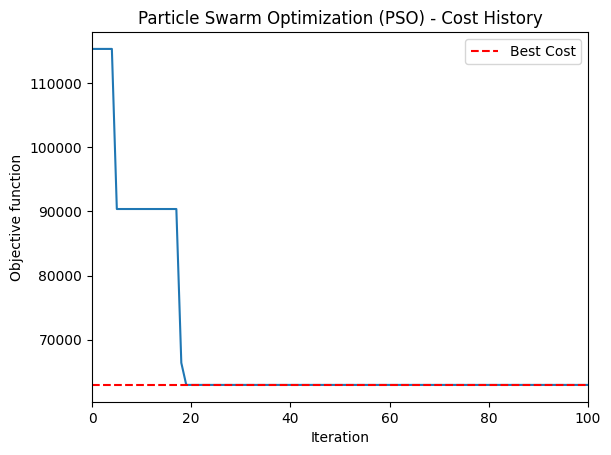

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 62961.37931275644
Tempo de Convergência para a segunda etapa: 1.0390710830688477 segundos


In [695]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 1.000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

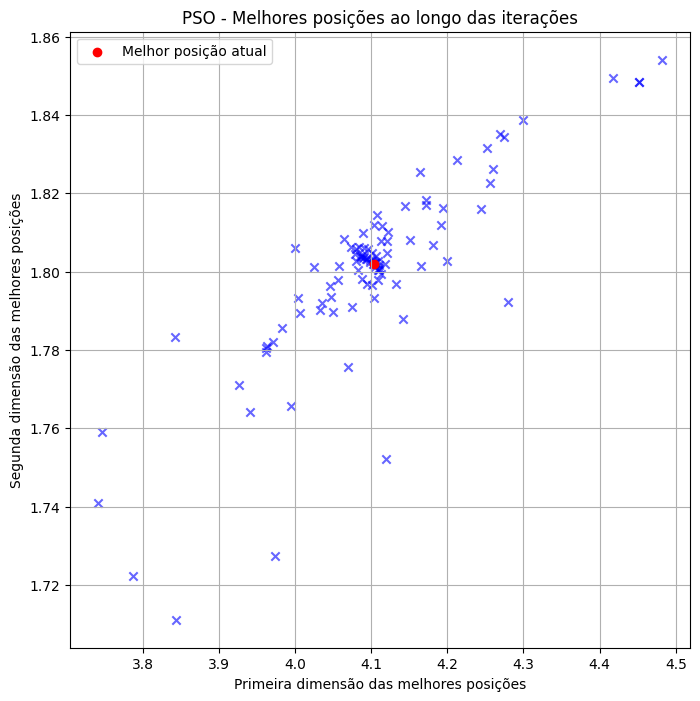

In [696]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [703]:
# # Nome do arquivo CSV para salvar o resultado do melhor custo
# nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [704]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv', sep=",")
df.head()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196,12
1,2,1.113853e+08,122.786813,9.995324,0.286275,0.005789,1.427013,8
2,3,1.059578e+08,124.352022,9.998797,0.309419,0.007851,1.646344,9
3,4,4.224613e+07,122.765793,9.998811,0.363530,0.011067,1.599882,8
4,5,1.013309e+08,120.763712,9.993543,0.417036,0.022115,1.480646,14


In [705]:
df.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,1.473235e+08,123.205073,9.993446,0.312531,0.011179,1.469604,9.000000
std,3.02765,1.071680e+08,1.701466,0.006043,0.077950,0.004829,0.108092,2.538591
min,1.00000,4.224613e+07,120.713917,9.980213,0.197210,0.005789,1.301908,5.000000
25%,3.25000,1.024876e+08,122.638986,9.991739,0.279276,0.008451,1.415772,8.000000
50%,5.50000,1.097181e+08,123.040587,9.995638,0.298754,0.009683,1.466480,8.500000
75%,7.75000,1.566829e+08,124.170901,9.997644,0.358638,0.011629,1.533150,9.750000
max,10.00000,4.221348e+08,126.031231,9.998811,0.431321,0.022115,1.646344,14.000000


In [743]:
# Seus arrays de tempos e severidade
Tempos = [
    [[0, 75, 102, 131, 174, 238, 343, 384, 433, 490, 523, 560, 575]],
    [[0, 198, 236, 325, 330, 370, 402, 488, 518]],
    [[0, 83, 150, 188, 257, 311, 330, 385, 463, 582]],
    [[0, 5, 42, 68, 186, 215, 305, 365, 504]],
    [[0, 22, 33, 60, 104, 134, 162, 245, 325, 334, 404, 462, 500, 512, 612]],
    [[0, 10, 112, 294, 311, 663]],
    [[0, 47, 83, 137, 156, 226, 395, 637]],
    [[0, 29, 49, 97, 144, 157, 276, 318, 393, 504, 556]],
    [[0, 11, 202, 225, 261, 292, 302, 382, 504, 545]],
    [[0, 14, 62, 205, 215, 313, 340, 423, 551]],
]

severidade = [
    [[0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5]],
    [[0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25]],
    [[0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]],
    [[0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]],
    [[0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5]],
    [[0.75, 0.75, 0.75, 0.75, 0.5]],
    [[0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25]],
    [[0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75]],
    [[0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]],
    [[0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25]],
]

# Verifique se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenariociclo_tempo_severidade.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")


In [744]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenariociclo_tempo_severidade.csv', sep=";")
df.head()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,"[0, 75, 102, 131, 174, 238, 343, 384, 433, 490...","[0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0...."
1,"[0, 198, 236, 325, 330, 370, 402, 488, 518]","[0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25]"
2,"[0, 83, 150, 188, 257, 311, 330, 385, 463, 582]","[0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, ..."
3,"[0, 5, 42, 68, 186, 215, 305, 365, 504]","[0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]"
4,"[0, 22, 33, 60, 104, 134, 162, 245, 325, 334, ...","[0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0..."
